# Case Study :  SMS Spam Detection

## Ashutosh Gupta

#### Problem Statement
- Predict whether given SMS is spam or not, based on text feature extracted from text.
- We will extract the features from the SMS text:
- The data file has 2 columns, v1 and v2
- Data has 5572 records
- v2 has sms text and v2 has got the whether text is spam or not
- v1 has 2 type of values
> - spam
> - ham
- 747 records are spam and 4825 are ham

In [118]:
import pandas as pd #data manipulation using dataframes
import numpy as np #data statistical analysis 
import matplotlib.pyplot as plt # data visualisation
import seaborn as sns # Statistical data visualization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from pandas.tools.plotting import table
import re  
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
# %matplotlib inline

## Loading and Exploring Data

In [295]:
data = pd.read_csv("spam.csv", encoding = "ISO-8859-1")

In [281]:
print(data.shape)
# print(data.describe)

(5572, 2)


In [282]:
print(data['v1'].value_counts())

ham     4825
spam     747
Name: v1, dtype: int64


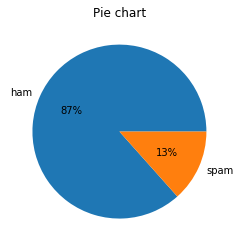

In [38]:
data['v1'].value_counts().plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

## Text Analytics

I am trying to find the most comman words in Spam and Non-Spam type

In [65]:
count1 = Counter(" ".join(data[data["v1"] == "ham"]["v2"]).split()).most_common(20)
df1 = pd.DataFrame().from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})

count2 = Counter(" ".join(data[data["v1"] == "spam"]["v2"]).split()).most_common(20)
df2 = pd.DataFrame().from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count"})

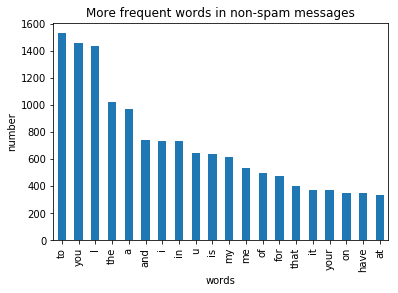

In [66]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

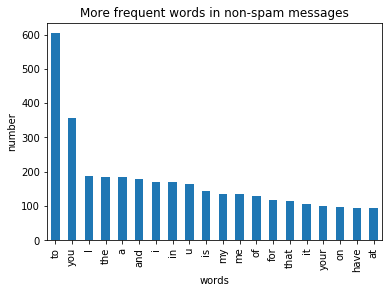

In [67]:
df2.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

We can see that in both spam and non-spam senetences most common words are stop words.
In next step we will remove the stop words.

In [296]:
data['v1'] = data["v1"].map({'spam':1,'ham':0})

In [125]:
target = data['v1'].values
print(target.shape)
X_data = data.drop(['v1'], axis=1)
print(X_data.shape)

(5572,)
(5572, 2)


In [341]:
vectorizer = CountVectorizer(stop_words = 'english')
X = vectorizer.fit_transform(X_data['v2'])

In [342]:
print(X.shape)

(5572, 8411)


In [343]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.25, random_state=1)

In [344]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179, 8411)
(1393, 8411)
(4179,)
(1393,)


In [345]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
from sklearn.svm import SVC
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)

mnb = MultinomialNB()
mnb.fit(X_train.toarray(), y_train)

svm = SVC()
svm.fit(X_train.toarray(), y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [346]:
gnb_pred = gnb.predict(X_test.toarray())
mnb_pred = mnb.predict(X_test.toarray())
svm_pred = svm.predict(X_test.toarray())

In [347]:
print(accuracy_score(y_test, gnb_pred))
print(accuracy_score(y_test, mnb_pred))
print(accuracy_score(y_test, svm_pred))

0.8923187365398421
0.9813352476669059
0.8707824838478104


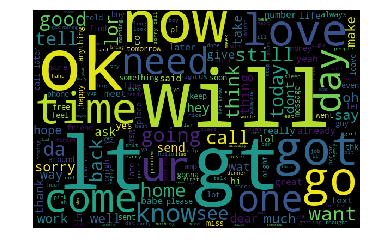

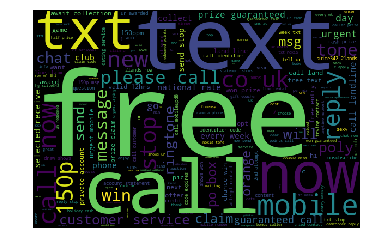

In [348]:
def visualize(label):
  words = ''
  for msg in data[data['v1'] == label]['v2']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

visualize(0) #ham
visualize(1) #spam

In [349]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, mnb_pred)
pd.DataFrame(data = cm, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1196,17
Actual 1,9,171


In [350]:
cm = confusion_matrix(y_test, gnb_pred)
pd.DataFrame(data = cm, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1072,141
Actual 1,9,171


In [351]:
cm = confusion_matrix(y_test, svm_pred)
pd.DataFrame(data = cm, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1213,0
Actual 1,180,0


We can see that Multinomial NB is giving best result interms of accuracy and in terms of confusion matrix.
Now we will try to further improve the model by using finding best parameters of the models

## Multinomial Naive Bayes with different values for parameters


In [318]:
alpha_values = np.arange(1/100000, 30, 0.10)
count = 0
test_score = np.zeros(len(alpha_values))
train_score = np.zeros(len(alpha_values))
test_precision = np.zeros(len(alpha_values))
test_recall = np.zeros(len(alpha_values))

for alpha in alpha_values:
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train.toarray(), y_train)
    pred = model.predict(X_test.toarray())
    train_score[count] = model.score(X_train.toarray(), y_train)
    test_score[count] = model.score(X_test.toarray(), y_test)
    test_precision[count] = metrics.precision_score(y_test, pred)
    test_recall[count] = metrics.recall_score(y_test, pred)
    count = count + 1


#### Creating dataframe with the obtained values

In [319]:
matrix = np.array(np.c_[alpha_values, train_score, test_score, test_recall, test_precision])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.998804,0.980617,0.944444,0.909091
1,0.10001,0.998325,0.983489,0.944444,0.928962
2,0.20001,0.997607,0.984925,0.938889,0.944134
3,0.30001,0.995693,0.987078,0.922222,0.976471
4,0.40001,0.994257,0.987078,0.911111,0.987952
5,0.50001,0.992582,0.987796,0.905556,1.000000
6,0.60001,0.991146,0.986360,0.894444,1.000000
7,0.70001,0.988035,0.982053,0.861111,1.000000
8,0.80001,0.983967,0.980617,0.850000,1.000000
9,0.90001,0.981335,0.977028,0.822222,1.000000


#### Finding the data with Test Precision with 100% rate
- It is important for us to find the parameter which gives us 100 precision rate
- If a message is spam and predicted as non-spam, this situation would easier to handle as compared to the situation
    where the a non-spam message is predicted as spam.
- That's why we are concerned about precision, as precision describes the false-positive rate which means in our case
    all those cases which are non-spam and marked as spam.
- If recall which is false-negetive rate represents spam which is marked as non-spam , is not 100% we can still manage.

In [320]:
best_index = models["Test Precision"].idxmax()
print(models.iloc[best_index, :])


alpha             0.500010
Train Accuracy    0.992582
Test Accuracy     0.987796
Test Recall       0.905556
Test Precision    1.000000
Name: 5, dtype: float64


#### There could more data points with Test Precision as 1

In [321]:
models[models["Test Precision"]==1].head(5)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
5,0.50001,0.992582,0.987796,0.905556,1.0
6,0.60001,0.991146,0.986360,0.894444,1.0
7,0.70001,0.988035,0.982053,0.861111,1.0
8,0.80001,0.983967,0.980617,0.850000,1.0
9,0.90001,0.981335,0.977028,0.822222,1.0


#### We are looking for data of 100% test precision with max test accuracy

In [322]:
best_index = models[models["Test Precision"]==1]['Test Accuracy'].idxmax()

mnb = MultinomialNB(alpha=alpha_values[best_index])
mnb.fit(X_train, y_train)
print(models.iloc[best_index, :])


alpha             0.500010
Train Accuracy    0.992582
Test Accuracy     0.987796
Test Recall       0.905556
Test Precision    1.000000
Name: 5, dtype: float64


#### Confusion Matrix for the best parameter trained model

In [323]:
cm = confusion_matrix(y_test, mnb.predict(X_test.toarray()))
pd.DataFrame(data = cm, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])


,Predicted 0,Predicted 1
Actual 0,1213,0
Actual 1,17,163


#### We are misqualifying 17 messages

### We will repeat above technique for svm classifier

In [352]:
import warnings
warnings.filterwarnings('ignore')

C_values = np.arange(1, 2000, 1)
count = 0
test_score = np.zeros(len(C_values))
train_score = np.zeros(len(C_values))
test_precision = np.zeros(len(C_values))
test_recall = np.zeros(len(C_values))

for c in C_values:
    svm = SVC(C=c, gamma='auto')
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)
    train_score[count] = svm.score(X_train.toarray(), y_train)
    test_score[count] = svm.score(X_test.toarray(), y_test)
    test_precision[count] = metrics.precision_score(y_test, pred)
    test_recall[count] = metrics.recall_score(y_test, pred)
    count = count + 1

#### Preparaing dataframe

In [353]:
matrix = np.array(np.c_[C_values, train_score, test_score, test_recall, test_precision])
models = pd.DataFrame(data=matrix, 
            columns = ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(10)

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,1.0,0.864322,0.870782,0.000000,0.0
1,2.0,0.864322,0.870782,0.000000,0.0
2,3.0,0.864322,0.870782,0.000000,0.0
3,4.0,0.864322,0.870782,0.000000,0.0
4,5.0,0.864322,0.870782,0.000000,0.0
5,6.0,0.864800,0.872218,0.011111,1.0
6,7.0,0.866954,0.876525,0.044444,1.0
7,8.0,0.872697,0.882268,0.088889,1.0
8,9.0,0.876765,0.888729,0.138889,1.0
9,10.0,0.887054,0.897344,0.205556,1.0


#### Finding the data with maximum Test Precision

In [354]:
best_index = models[models["Test Precision"] == 1].idxmax()
models.iloc[best_index, :]

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
320,321.0,0.990907,0.985642,0.888889,1.0
319,320.0,0.990907,0.985642,0.888889,1.0
243,244.0,0.987796,0.985642,0.888889,1.0
243,244.0,0.987796,0.985642,0.888889,1.0
5,6.0,0.864800,0.872218,0.011111,1.0


#### Finding data with 100% precision and having highest test accuracy

In [355]:
best_index = models[models["Test Precision"] == 1]["Test Accuracy"].idxmax()

models.iloc[best_index, :]

C                 244.000000
Train Accuracy      0.987796
Test Accuracy       0.985642
Test Recall         0.888889
Test Precision      1.000000
Name: 243, dtype: float64

In [356]:
svm = SVC(C = C_values[best_index])
svm.fit(X_train.toarray(), y_train)


SVC(C=244, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

#### Confusion Matrix for best parameters of model

In [357]:
cm = confusion_matrix(y_test, svm.predict(X_test.toarray()))
pd.DataFrame(data = cm, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])



,Predicted 0,Predicted 1
Actual 0,1213,0
Actual 1,20,160


#### Above we compare 2 classification models using accuracy, precision and recall
- We found that both models are performing almost similar
- Multinomial Naive bayes is doing alighly better then SVM
- For any further computation for this model we will carry on with MNB

In [ ]:
data["prediction"] = mnb.predict(X)

In [ ]:
data

In [ ]:
##things that should not be spam but are spam
sneaky_sms = data[(data["prediction"] == 1) & (data['v1'] == 0)]["v2"]

In [ ]:
##things that should be spam but are not spam
non_sneaky_sms = df_data[(df_data["prediction"] == 0) & (df_data['v1'] == 1)]["v2"]

### Checking if my model is performing fine

In [364]:
def check_model(text):
    vectorizer = CountVectorizer(stop_words = 'english')
    vectorizer.fit(data['v2'])
    X = vectorizer.transform(text)
    res = mnb.predict(X)
    if res[0] == 0:
        print("The given text is not Spam.")
    else:
        print("The given text is Spam.")
    


In [365]:
text = ["Despite the high number of votes: this answer is wrong. Note that the OP has a dataframe with non continuous indexes and e (Series(np.random.randn(sLength))) generates a Series 0-n indexed. If you assign this to df1 then you get some NaN cells."]
check_model(text)

The given text is not Spam.


In [372]:
check_model(["Get free t-shirts, just send $100 to given account number"])

The given text is Spam.
